# Fashion Search AI 

## Scope of Project:
#### The AI helps to search the required information about the fashion trends and clothing from Myntra app for easy and effective retrieval of information and necessary details on providing the user query

## Project Overview and Implementation

### Embedding layer:
### It is necessary to cleanup preprocess and chunk the dataset. The chunking is performed based on available data collection. The data is kept ready for embedding

### Search Layer:
### The index serach is performed on the embedding layer to retrieve the necessary data based on the query received from the user. Cache is also implemented for faster and easy retrieval.

### Generative Layer:
### We use LLM from OpenAI in this layer. The data from the Search layer is given to LLM along with properly constructed prompt and query.This performs the semantic search to retrieve the top n results from the trained data based on user query

### Install libraries

In [8]:
!pip install pdfplumber
!pip install chromadb
!pip install tiktoken
!pip install openai
!pip install sentence-transformers

### Import libraries

In [34]:
import tiktoken  # Assuming this is a custom library for tokenization
import openai  # OpenAI library for accessing GPT models
import chromadb  # ChromaDB library for database operations
from pathlib import Path  # For handling file paths
import pandas as pd  # Pandas for data manipulation
from operator import itemgetter  # For sorting dictionaries
import json  # For working with JSON data
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF vectorizer
from sklearn.metrics.pairwise import cosine_similarity  # Cosine similarity calculation
from nltk.corpus import stopwords  # Stopwords for text processing
from nltk.tokenize import word_tokenize  # Tokenization
import string  # String manipulation functions
from PIL import Image  # Image processing library
import requests  # For making HTTP requests
from io import BytesIO  # For handling binary data
import matplotlib.pyplot as plt  # Matplotlib for visualization
from matplotlib import table  # Table visualization in Matplotlib
import os  # Operating system utilities
import matplotlib.image as mpimg

# Import the CrossEncoder library from sentence_transformers
##from sentence_transformers import CrossEncoder, util
# Importing required functions and classes from ChromaDB
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [35]:
file_path = 'C:/Users/test/Desktop/ArMan/02 _ Manasa Documents/Educarion/AiI-ML 2023/NLP/Gen AI/RAG/Fashion Dataset v2.csv'

## Read data 
fashion_data = pd.read_csv(file_path)


In [36]:
## Display data
fashion_data.head(5)

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products   price     colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0     Orange    InWeave   
2               Kurta, Trousers, Dupatta  4899.0  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta  3699.0        Red       Nayo   
4                                  Kurta  1350.0      Black      AHIKA   

                                                 img  ratingCount  avg_rating  \
0  http://assets.myntassets.com/assets/images/170...       4522.0    4.418399   
1  http://assets.myntassets.com/assets/images/165...       1081.0    4.119334   
2  http://assets.myntassets.com/assets/images/163...       1752.0    4.161530   
3  http://assets.myntassets.com/assets/images/147...       4113.0    4.088986   
4  http://assets.myntassets.com/assets/images/110...      21274.0    3.978377   

                                         description  \
0  Black printed Kurta with Palazzos with dupatta...   
1  Orange solid Kurta with Palazzos with dupatta<...   
2  Navy blue embroidered Kurta with Trousers with...   
3  Red printed kurta with trouser and dupatta<br>...   
4  Black and green printed straight kurta, has a ...   

                                        p_attributes  
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
4  {'Body Shape ID': '424', 'Body or Garment Size...

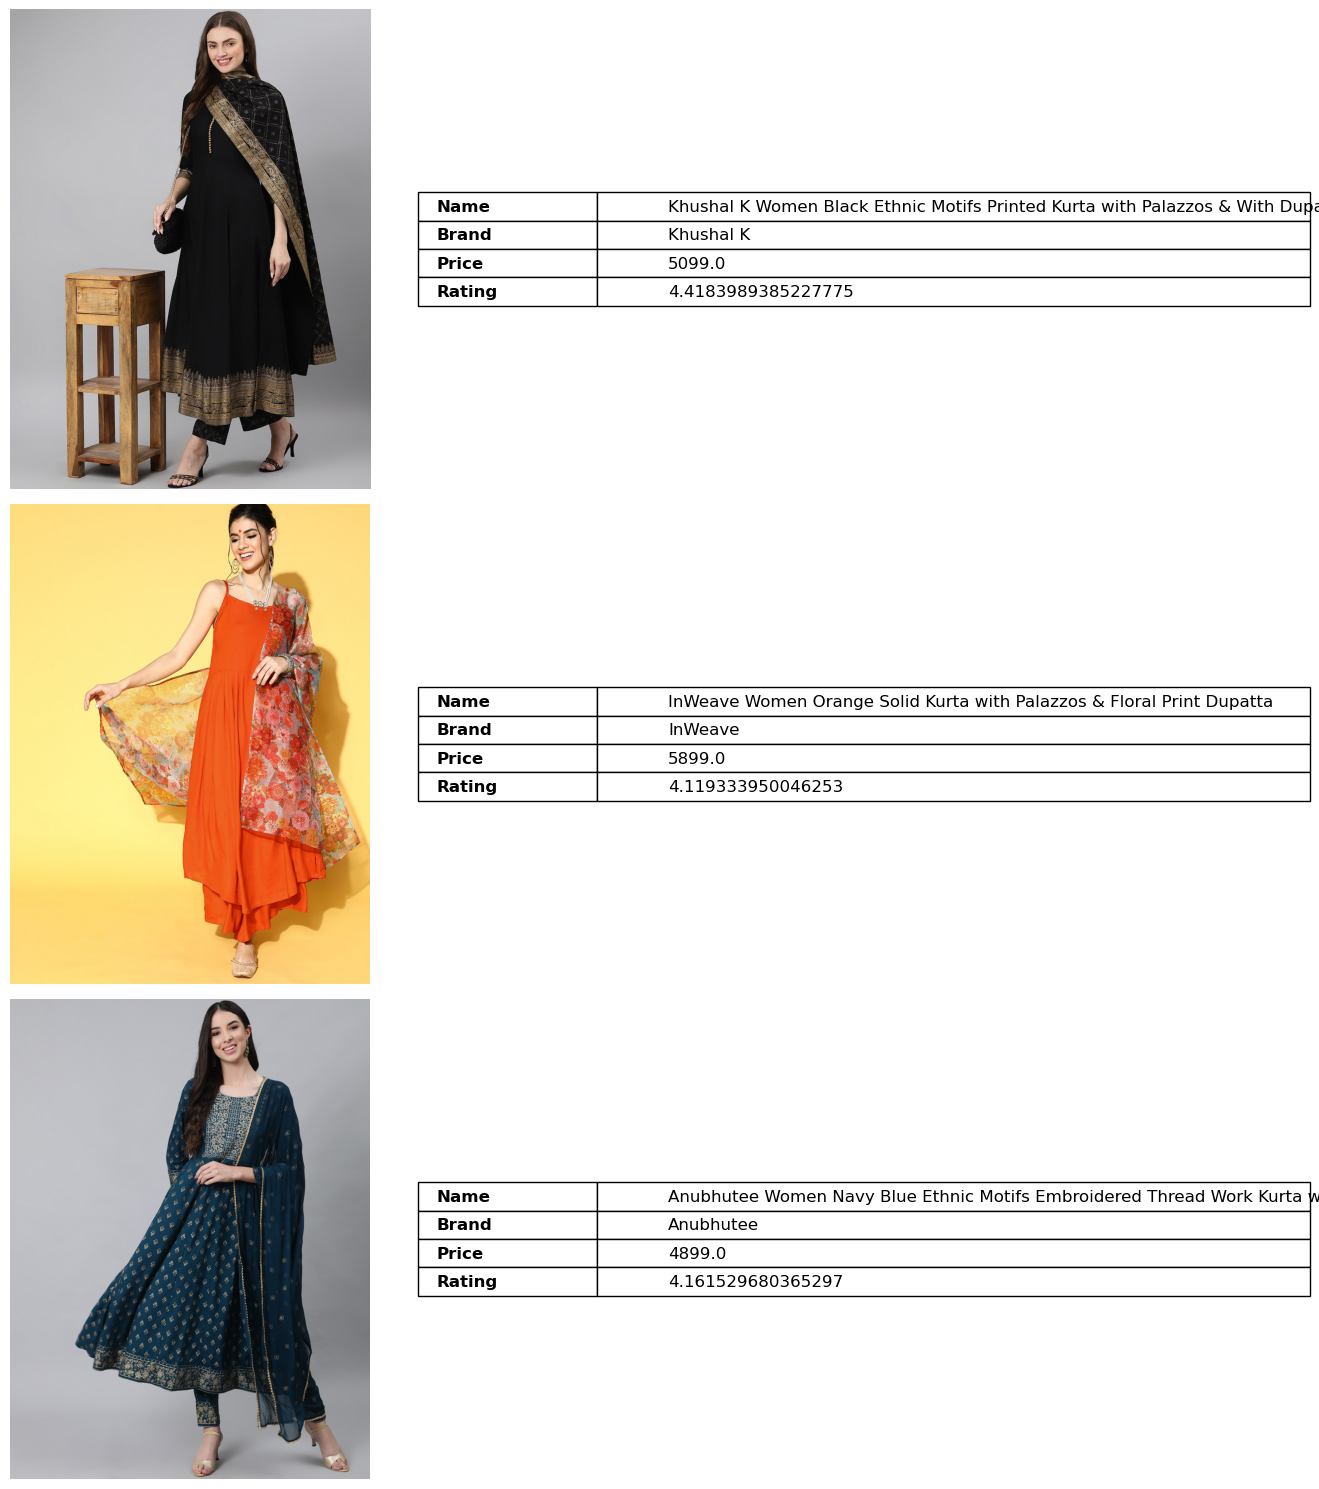

In [37]:
# Define the path to the images folder
images_folder_path = 'C:/Users/test/Desktop/ArMan/02 _ Manasa Documents/Educarion/AiI-ML 2023/NLP/Gen AI/RAG/images'

# Define a function to display images with mini tables
def display_images_with_info(df, images_folder_path, num_images=3):
    """
    Display images with accompanying mini tables containing information from the DataFrame.

    Args:
    - df: DataFrame containing image information
    - images_folder_path: Path to the folder containing the images
    - num_images: Number of images to display

    Returns:
    None
    """
    # Create subplots to display images and mini tables
    fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

    # Iterate over each row in the DataFrame and display the image with mini table
    for i, (idx, row) in enumerate(df.head(num_images).iterrows()):
        # Construct the path to the image file
        image_path = os.path.join(images_folder_path, str(row['p_id']) + '.jpg')

        # Check if the image file exists
        if os.path.exists(image_path):
            # Open the image file
            img = Image.open(image_path)

            # Display the image
            axes[i, 0].imshow(img)
            axes[i, 0].axis('off')

            # Create a mini table with information from the DataFrame
            table_data = [['Name', row['name']],
                          ['Brand', row['brand']],
                          ['Price', row['price']],
                          ['Rating', row['avg_rating']]]

            axes[i, 1].axis('off')
            mini_table = axes[i, 1].table(cellText=table_data, loc='center', cellLoc='left', colWidths=[0.2, 0.8])

            # Format the mini table
            for cell in mini_table.get_celld().values():
                if cell.get_text().get_text() in ['Name', 'Brand', 'Price', 'Rating']:
                    cell.get_text().set_fontweight('bold')
                cell.get_text().set_fontsize(12)

            # Set font size explicitly for all cells
            mini_table.auto_set_font_size(False)
            mini_table.set_fontsize(12)
            mini_table.scale(1.2, 1.2)  # Adjust the scaling factor as needed
        else:
            print(f"Image not found for p_id: {row['p_id']}")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Display images with mini tables for the first 3 images
display_images_with_info(fashion_data, images_folder_path, num_images=3)

In [38]:
fashion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14214 entries, 0 to 14213
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   p_id          14214 non-null  int64  
 1   name          14214 non-null  object 
 2   products      14214 non-null  object 
 3   price         14214 non-null  float64
 4   colour        14214 non-null  object 
 5   brand         14214 non-null  object 
 6   img           14214 non-null  object 
 7   ratingCount   6530 non-null   float64
 8   avg_rating    6530 non-null   float64
 9   description   14214 non-null  object 
 10  p_attributes  14214 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.2+ MB


## Dataset Chunking
### In this project, dataset chunking is not done as the data is in a very structured manner and is not necessary to chunk further. The available data format is suitable for the further implementation.

## Generate and store Embeddings using OpenAI and ChromaDB

In [39]:
# Import the OpenAI Embedding Function into chroma
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [40]:
# Define the path where chroma collections will be stored

chroma_data_path = "C:/Users/test/Desktop/ArMan/02 _ Manasa Documents/Educarion/AiI-ML 2023/NLP/Gen AI/RAG/ChromaDB_Data"

In [41]:
# Call PersistentClient()
client = chromadb.PersistentClient(path=chroma_data_path)

In [42]:
# # If you're using the default OpenAI API key, uncomment the following lines:
import openai
openai.api_key = open("OPENAI_API_Key.txt", "r").read().strip()
##os.environ['OPENAI_API_KEY'] = openai.api_key

In [43]:
# Set up the embedding function using the OpenAI embedding model
model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [44]:
fashion_data.head(5)

p_id                                               name  \
0  17048614  Khushal K Women Black Ethnic Motifs Printed Ku...   
1  16524740  InWeave Women Orange Solid Kurta with Palazzos...   
2  16331376  Anubhutee Women Navy Blue Ethnic Motifs Embroi...   
3  14709966  Nayo Women Red Floral Printed Kurta With Trous...   
4  11056154   AHIKA Women Black & Green Printed Straight Kurta   

                                products   price     colour      brand  \
0               Kurta, Palazzos, Dupatta  5099.0      Black  Khushal K   
1  Kurta, Palazzos, Floral Print Dupatta  5899.0     Orange    InWeave   
2               Kurta, Trousers, Dupatta  4899.0  Navy Blue  Anubhutee   
3                Kurta, Trouser, Dupatta  3699.0        Red       Nayo   
4                                  Kurta  1350.0      Black      AHIKA   

                                                 img  ratingCount  avg_rating  \
0  http://assets.myntassets.com/assets/images/170...       4522.0    4.418399   
1  http://assets.myntassets.com/assets/images/165...       1081.0    4.119334   
2  http://assets.myntassets.com/assets/images/163...       1752.0    4.161530   
3  http://assets.myntassets.com/assets/images/147...       4113.0    4.088986   
4  http://assets.myntassets.com/assets/images/110...      21274.0    3.978377   

                                         description  \
0  Black printed Kurta with Palazzos with dupatta...   
1  Orange solid Kurta with Palazzos with dupatta<...   
2  Navy blue embroidered Kurta with Trousers with...   
3  Red printed kurta with trouser and dupatta<br>...   
4  Black and green printed straight kurta, has a ...   

                                        p_attributes  
0  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
1  {'Add-Ons': 'NA', 'Body Shape ID': '443,333,32...  
2  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
3  {'Add-Ons': 'NA', 'Body Shape ID': '333,424', ...  
4  {'Body Shape ID': '424', 'Body or Garment Size...

In [45]:
# Convert the data to a dictionary format with metadata
fashion_data['metadata'] = fashion_data.apply(
    lambda x: {
        'Product_id': x['p_id'],  # Unique identifier for the product
        'Name': x['name'],  # Product name
        'Product_type': x['products'],  # Type or category of the product
        'Price_INR': x['price'],  # Price of the product in Indian Rupees
        'Colour': x['colour'],  # Color of the product
        'Brand': x['brand'],  # Brand of the product
        'RatingCount': x['ratingCount'],  # Number of ratings received
        'Rating': x['avg_rating'],  # Average rating of the product
        'Description': x['description'],  # Description of the product
        'Product_attributes': x['p_attributes']  # Additional attributes of the product
    }, axis=1
)

In [46]:
# Function to extract text for embedding
def extract_text(metadata):
    """
    Extracts text content from the metadata dictionary for embedding.

    Args:
    metadata (dict): Dictionary containing metadata information.

    Returns:
    str: Text content extracted from the metadata.
    """
    text_content = ""
    if "Description" in metadata and metadata["Description"]:
        text_content += metadata["Description"]  # Add product description
    if "name" in metadata:
        text_content += " " + metadata["name"]  # Add product name
    if not text_content:
        text_content = "No description available."
    return text_content.strip()  # Strip leading and trailing whitespace

In [47]:
# Extract text for embedding from each row of metadata
documents = [extract_text(row['metadata']) for _, row in fashion_data.iterrows()]

In [48]:
# Get or create a ChromaDB collection for fashion products
fashion_collection = client.get_or_create_collection(name='Fashion_Products', embedding_function=embedding_function)

In [ ]:
# Add the data to the ChromaDB collection
for idx, (p_id, metadata) in enumerate(zip(fashion_data['p_id'], fashion_data['metadata'])):
    print(f"Processing document with p_id={p_id}")
    print(f"Document text: {documents[idx]}")
    fashion_collection.add(
        documents=[documents[idx]],  # Text content of the document
        ids=[str(p_id)],  # Unique identifier of the document
        metadatas=[metadata]  # Metadata associated with the document
    )

In [49]:
fashion_collection.peek(1)

{'ids': ['10019867'],
 'embeddings': [[-0.026131153106689453,
   -0.016600508242845535,
   0.0012238806812092662,
   -0.014400127343833447,
   -0.006083598360419273,
   0.01670466922223568,
   -0.0242041926831007,
   0.001957883592694998,
   -0.0035544619895517826,
   -0.032471898943185806,
   0.022003810852766037,
   0.025180693715810776,
   0.01658748835325241,
   -0.00853461492806673,
   -0.017433788627386093,
   0.022485552355647087,
   0.011034456081688404,
   -8.00018387963064e-05,
   -0.012329946272075176,
   -0.005234042648226023,
   -0.013736107386648655,
   0.007375834044069052,
   0.017407748848199844,
   -0.004924817476421595,
   -0.001992061035707593,
   0.007388853933662176,
   0.025844713672995567,
   -0.017290569841861725,
   0.014022547751665115,
   -0.005064782686531544,
   0.02710765413939953,
   -0.010533185675740242,
   0.002752103842794895,
   -0.027966974303126335,
   -0.0018341934774070978,
   0.0008991942158900201,
   0.006409098394215107,
   0.0029376391321420

In [50]:
cache_collection = client.get_or_create_collection(name="Fashion_cache",embedding_function=embedding_function)

In [51]:
cache_collection.peek()

{'ids': ['I am looking for bright colored summer wear',
  'I am looking for red colored polo t-shirts',
  'I am looking for yellow colored cotton kurtis',
  'I am looking for yellow colored cotton saree'],
 'embeddings': [[-0.020589813590049744,
   -0.0015844454756006598,
   -0.0023407668340951204,
   -0.023678923025727272,
   -0.008552495390176773,
   0.042047642171382904,
   -0.03285690024495125,
   0.010614029131829739,
   0.0152668422088027,
   -0.00772277545183897,
   0.0019338851561769843,
   -0.003047624137252569,
   0.00808019284158945,
   -0.006162264384329319,
   -0.0006390436901710927,
   -0.0028641284443438053,
   0.02823599986732006,
   -0.013594637624919415,
   0.010473615489900112,
   -0.011418219655752182,
   -0.015662554651498795,
   0.0026359555777162313,
   -0.00980983953922987,
   0.0030540067236870527,
   -5.400781901698792e-06,
   -0.015700848773121834,
   0.0173219945281744,
   -0.021751420572400093,
   0.0013012238778173923,
   -0.00225779484026134,
   0.0332398

## Semantic search with cache
### We have created 2 collections : cache_collection and fashion_collection.The strategy is that once we the system gets a user query, we search for the result in cache and if the cache does not contain the required result we search in the main collection.The query along with the searched collection is stored in the cache for further usage and also output to the user.

In [123]:
query = input("Enter the user query with brief explaination of what is required. For eg: color, type of clothing, brand, size etc")
#Query1: "I am looking for a bright colored long cotton coat suitable with blue and black jeans with fancy top"
#Query2: "I want to buy a elegant saree with a professional look for office wear and price ranging in between 3000 to 6000 Rs"
#Query3: "I am seeking a good quality stylish summer wear in Adidas or Tommy Hilfiger brand"
#Query4: "I need an ethenic wear suitable for festivals and wearable in summer as well as winter. I wish it to be in a bright color and within 8000 range"

Enter the user query with brief explaination of what is required. For eg: color, type of clothing, brand, size etc Suggest me some good wedding attire.


In [124]:
query

'Suggest me some good wedding attire.'

In [125]:
## Querying the cache collection first
cache_results = cache_collection.query(
    query_texts=query,  # User query
    n_results=3  # Number of results to retrieve
)
cache_results

{'ids': [['Suggest me some good fashionable skirts',
   'I am looking for bright colored summer wear',
   'I am looking for yellow colored cotton saree']],
 'distances': [[0.22649924295496954, 0.3360265519843554, 0.33766643670751995]],
 'metadatas': [[{'distances0': '0.2574610412120819',
    'distances1': '0.26532167196273804',
    'distances2': '0.26685819029808044',
    'distances3': '0.2672416567802429',
    'distances4': '0.26926949620246887',
    'documents0': "Flaunt your chic style when you step out donning this smart and versatile skirt. It features a lovely floral print and straight hemline.&nbsp;<ul><li>Attractive red tone</li><li>Floral print</li><li>Straight hemline</li><li>Above knee length</li><li>Polyester, machine wash</li></ul><b>Trend Alert</b><br>Ensembles accentuated by details, such as buttoning, slits, cutouts, gathers, wraps, the Roman column trend brings back old-worldly charm. It boasts prints, like stripes, floral, and colourblocking for an elevated appeal.Pol

In [126]:
## Since there is nothing in the cache lets get the response from the fashion_collection 
results = fashion_collection.query(
    query_texts=query,  # User query provided as input
    n_results=3  # Number of results to retrieve, in this case, the top 3 most relevant results
)


In [127]:
results

{'ids': [['16857572', '16857658', '17487194']],
 'distances': [[0.3836975693702698, 0.389972448348999, 0.39019450545310974]],
 'metadatas': [[{'Brand': 'Libas',
    'Colour': 'Black',
    'Description': "Our 3-piece black printed cotton suit set features a floral print straight-fit kurta with a notched neckline and Gota Patti accents on the yoke and sleeves, flared palazzo pants with a partially elasticated waistband and roomy pockets, and a complementing dupatta. A perfect pick for celebratory evenings.Pure Cotton<br>Gentle Machine WashThe model (height 5'8) is wearing a size S",
    'Name': 'Libas Women Black Floral Printed Gotta Patti Pure Cotton Kurta with Palazzos & With Dupatta',
    'Price_INR': 2999.0,
    'Product_attributes': "{'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'Slip-On', 'Bottom Fabric': 'Pure Cotton', 'Bottom Pattern': 'Printed', 'Bottom Type': 'Palazzos', 'Character': 'NA', 'Dupatta': '

In [128]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()

# Check if the distance is greater than the threshold, if so, return results from the main collection
if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
    # Query the collection against the user query and return the results
    results = fashion_collection.query(
        query_texts=query,
        n_results=5
    )

    # Store the query in cache_collection as a document with respect to ChromaDB for future reference
    # Store retrieved text, ids, distances, and metadatas in cache_collection as metadatas, so they can be fetched easily if a query indeed matches to a query in cache
    Keys = []
    Values = []

    for key, val in results.items():
        if val is None:
            continue
        for i in range(len(val[0])):  # Iterate over the actual length of val
            Keys.append(str(key) + str(i))
            if len(val[0]) > i:  # Check if the current index exists in val
                Values.append(str(val[0][i]))

    cache_collection.add(
        documents=[query],
        ids=[query],
        metadatas=dict(zip(Keys, Values))
    )

    # Print message indicating the results are found in the main collection
    print("Not found in cache. Found in the main collection.")

    # Construct a DataFrame from the query results
    result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs": results["ids"][0]}
    results_df = pd.DataFrame.from_dict(result_dict)


# If the distance is less than the threshold, return results from the cache
elif cache_results['distances'][0][0] <= threshold and cache_results['ids']:
    cache_result_dict = cache_results['metadatas'][0][0]

    # Loop through each inner list and then through the dictionary
    for key, value in cache_result_dict.items():
        if 'ids' in key:
            ids.append(value)
        elif 'documents' in key:
            documents.append(value)
        elif 'distances' in key:
            distances.append(value)
        elif 'metadatas' in key:
            metadatas.append(value)

    # Print message indicating the results are found in the cache
    print("Found in cache!")

    # Create a DataFrame from the cached results
    results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
    })
else:
    # Print message indicating no valid results found in cache
    print("No valid results found in cache!")

Not found in cache. Found in the main collection.


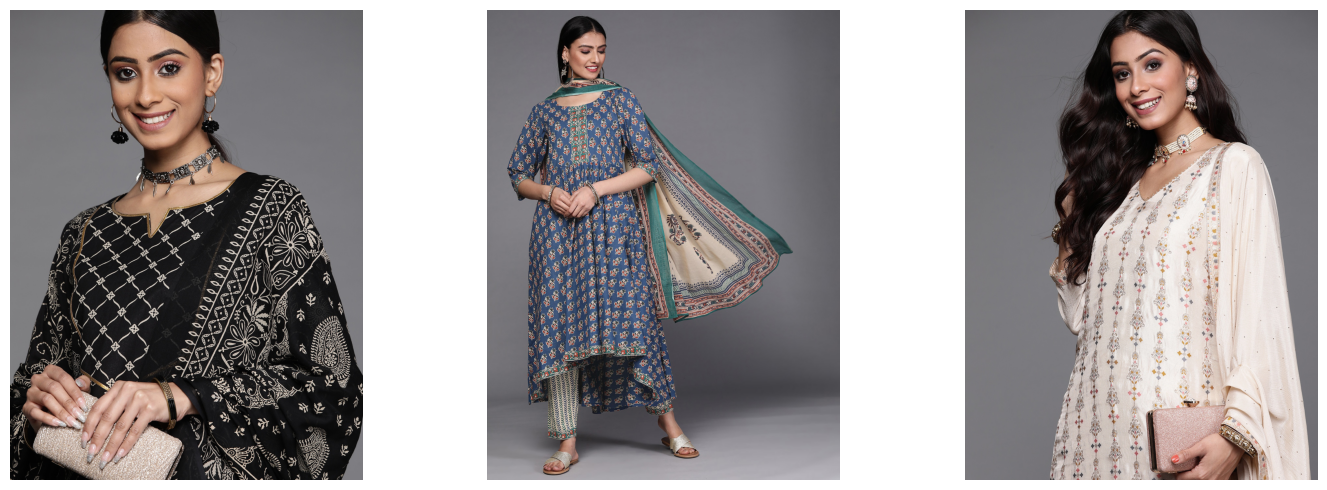

-------------------------------------------------------



dict_items([('ids', [['16857572', '16857658', '17487194']]), ('distances', [[0.3836975693702698, 0.389972448348999, 0.39019450545310974]]), ('metadatas', [[{'Brand': 'Libas', 'Colour': 'Black', 'Description': "Our 3-piece black printed cotton suit set features a floral print straight-fit kurta with a notched neckline and Gota Patti accents on the yoke and sleeves, flared palazzo pants with a partially elasticated waistband and roomy pockets, and a complementing dupatta. A perfect pick for celebratory evenings.Pure Cotton<br>Gentle Machine WashThe model (height 5'8) is wearing a size S", 'Name': 'Libas Women Black Floral Printed Gotta Patti Pure Cotton Kurta with Palazzos & With Dupatta', 'Price_INR': 2999.0, 'Product_attributes': "{'Add-Ons': 'NA', 'Body Shape ID': '443,333,324,424', 'Body or Garment Size': 'Garment Measurements in', 'Bottom Closure': 'Slip-On', 'Bottom Fabric': 'Pure Cotton', 'Bottom Pattern': 'Printed', 'Bottom Type': 'Palazzos', 'Character': 'NA', 'Dupatta': 'With D

In [129]:
# Query the fashion collection to retrieve relevant fashion items based on the user query
results = fashion_collection.query(
    query_texts=query,  # User query provided as input
    n_results=3  # Number of results to retrieve, in this case, the top 3 most relevant results
)


import matplotlib.pyplot as plt
import os
from PIL import Image

# Assuming you have already obtained the search results in the variable 'results'

# Extract the IDs of the fashion items from the search results
item_ids = results['ids'][0]  # Assuming the IDs are stored as the first element of the list

# Calculate the number of images
num_images = len(item_ids)

# Define the number of columns for the grid layout
num_cols = 3

# Calculate the number of rows needed based on the number of images and number of columns
num_rows = (num_images + num_cols - 1) // num_cols

# Set up the plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Display the images along with metadata
for i, item_id in enumerate(item_ids):
    # Construct the path to the image file
    image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
    else:
        axes[i].axis('off')
        axes[i].text(0.5, 0.5, f"Image not found for item ID: {item_id}",
                     fontsize=12, ha='center', va='center')

# Hide any remaining empty subplots
for j in range(num_images, num_rows * num_cols):
    axes[j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


print("-------------------------------------------------------\n")
# Extract and display the items retrieved from the search operation
results.items()

Query: 
Suggest me some good wedding attire.


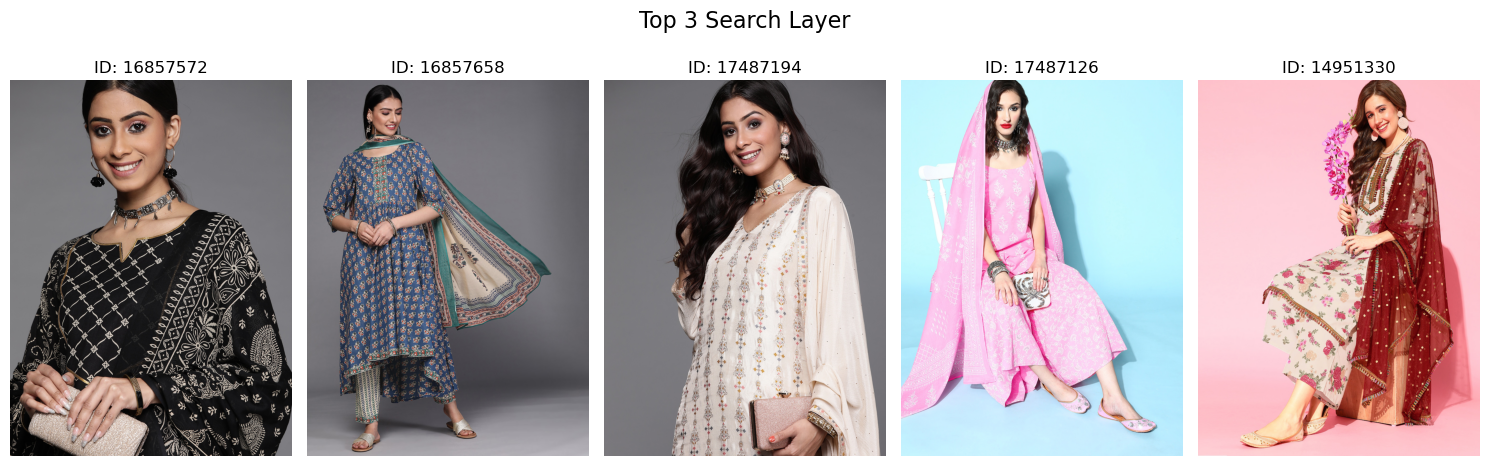

Metadatas  \
0  {'Brand': 'Libas', 'Colour': 'Black', 'Descrip...   
1  {'Brand': 'Libas', 'Colour': 'Blue', 'Descript...   
2  {'Brand': 'Libas', 'Colour': 'Beige', 'Descrip...   
3  {'Brand': 'Libas', 'Colour': 'Pink', 'Descript...   
4  {'Brand': 'Ahalyaa', 'Colour': 'Beige', 'Descr...   

                                           Documents  Distances       IDs  
0  Our 3-piece black printed cotton suit set feat...   0.383698  16857572  
1  Our 3-piece blue printed cotton suit set featu...   0.389972  16857658  
2  Our 3-piece beige woven design silk suit set f...   0.390195  17487194  
3  Our 3-piece pink floral print cotton suit set ...   0.393136  17487126  
4  When in doubt, rock this simple yet stylish ku...   0.395166  14951330

In [130]:
##For Screenshot

# Define the function to print query with a prefix and separator
def print_query_with_separator(prefix, query):
    # Print the prefix
    print(prefix)
    # Insert a newline character after every full stop
    query_with_newlines = query.replace(". ", ".\n")
    # Print the modified query
    print(query_with_newlines)

# Print the query with prefix and separator
print_query_with_separator("Query: ", query)

# Print the IDs from the results DataFrame
##print("IDs:")
#print(results_df['IDs'])


# Display images corresponding to the IDs side by side
num_images = len(results_df['IDs'])
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Set the title of the plot as the user query
fig.suptitle("Top 3 Search Layer", fontsize=16)

for i, item_id in enumerate(results_df['IDs']):
    # Construct the path to the image file
    image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"ID: {item_id}")
    else:
        print(f"Image not found for item ID: {item_id}")

plt.tight_layout()
plt.show()

results_df

## Retrieved Augmented Generation
#### Here we provide the semantic search results to the Generative AI layer that is to an LLM which responds with a direct answer to the query. A well engineered prompt along with the user query and search results from the above steps

For wedding attire suggestions, here are some elegant options you may consider:

1. **Libas Black Printed Cotton Suit Set**
   - Brand: Libas
   - Description: This 3-piece black printed cotton suit set features a stylish design, perfect for a formal wedding event.
   - Price: For current prices, please visit our website.
   
2. **Libas Blue Printed Cotton Suit Set**
   - Brand: Libas
   - Description: Embrace a pop of color with this 3-piece blue printed cotton suit set, ideal for adding a refreshing touch to your wedding look.
   - Price: Visit our website for the latest pricing information.
   
3. **Libas Beige Woven Design Silk Suit Set**
   - Brand: Libas
   - Description: Luxurious and sophisticated, this 3-piece beige woven design silk suit set exudes elegance, making it a great choice for a special occasion like a wedding.
   - Price: Check our website for current pricing details.
   
4. **Libas Pink Floral Print Cotton Suit Set**
   - Brand: Libas
   - Description: Stand out w

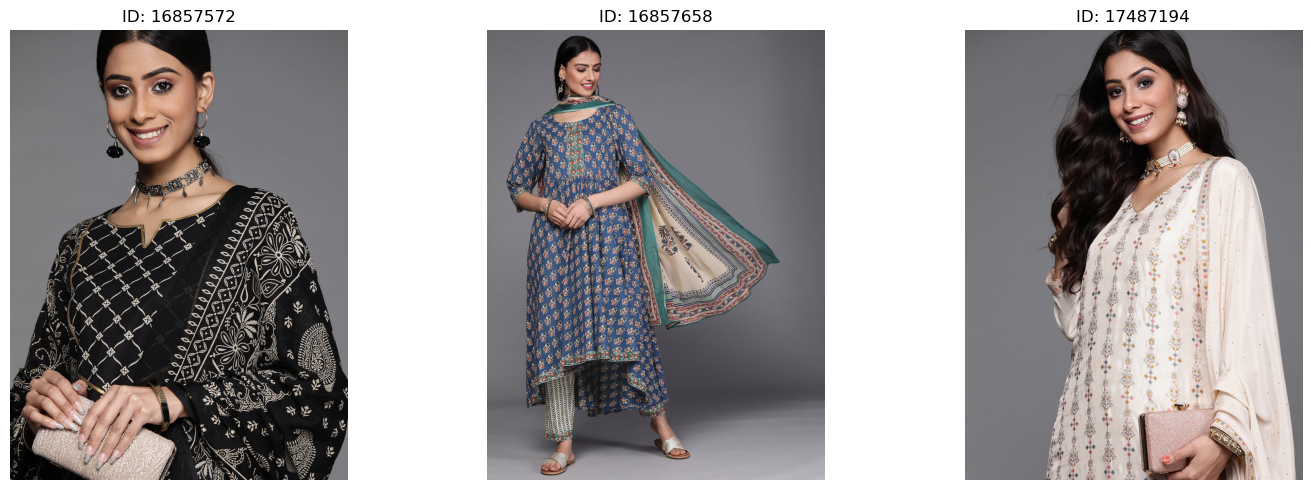

In [131]:
def generate_response_fashion(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
        {"role": "system", "content":  "You are a helpful AI assistant in the fashion domain, specialized in providing accurate answers to fashion-related queries."},
        {"role": "user", "content": f"""You have received a query from a user looking for fashion-related information. The query is: "{query}".
                                        Additionally, you have obtained the top 3 relevant results from the fashion dataset in the dataframe '{results_df}'.

                                        The 'Documents' column in this dataframe contains descriptions of fashion items, and the 'Metadatas' column contains additional information such as item name, brand.

                                        Your task is to use the information provided in '{results_df}' to generate a response to the query "{query}". Ensure that your response is informative and relevant to the user's query. Utilize the metadata to cite the relevant fashion items.

                                        Please adhere to the following guidelines:
                                        1. Provide accurate and relevant information based on the user query and the top 5 search results.
                                        2. You may use any relevant details from the dataframe to craft your response.
                                        3. If any of the fashion items contain tables or structured information, format and present it clearly.
                                        4. Use the metadata to cite the names, brands of the relevant fashion items.
                                        5. If you are unable to provide a complete answer, offer guidance on where the user can find further information within the cited fashion items.
                                        6. As a user-facing assistant, focus on delivering a direct and concise response without delving into technical details.
                                        7. Please note that detailed price and rating information might change from time to time. For more details,you should recommend to visit our website page.

                                        Your response should directly address the user's query and include citations for the referenced fashion items. Present the information in a well-organized and easily understandable format.
                                        """},
    ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    # Extracting p_ids directly from the 'IDs' column in top_3_RAG
    p_ids = results_df['IDs'].head(3).tolist()

    # Returning response and p_ids
    return response.choices[0].message.content, p_ids

# Generate response and p_ids based on the provided query and top_3_RAG DataFrame
response, p_ids = generate_response_fashion(query, results_df)

# Print the response
print(response)



# Display the images corresponding to the IDs obtained from the response side by side
num_images = len(p_ids)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, item_id in enumerate(p_ids):
    # Construct the path to the image file
    image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"ID: {item_id}")
    else:
        print(f"Image not found for item ID: {item_id}")

plt.tight_layout()
plt.show()


## Conclusion
#### The system is able to understand the user query, process the necessary steps right from embedding the user query until generating the top better results for the query.The generation layer's ability to understand the query context and generate responses in natural language makes the output more informative and user-friendly